In [1]:
import trackhhl.toy.simple_generator as toy
import trackhhl.event_model.q_event_model as em
import numpy as np
import itertools
import copy
import dimod
import psutil


import time
import tracemalloc
import matplotlib.pyplot as plt

  # For interacting with COM objects




In [2]:
def generate_hamiltonian(event, params):
    lambda_val = params.get('lambda')
    alpha = params.get('alpha')
    beta = params.get('beta')

    modules = copy.deepcopy(event.modules)
    modules.sort(key=lambda a: a.z)

    segments = [em.segment(from_hit, to_hit) for idx in range(len(modules) - 1) for from_hit, to_hit in itertools.product(modules[idx].hits, modules[idx + 1].hits)]
    N = len(segments)
    A = np.zeros((N, N))
    A_ang = np.zeros((N, N))
    A_bif = np.zeros((N, N))
    
    b = np.zeros(N)

    s_ab = np.zeros((N, N))
    for i, seg_i in enumerate(segments):
        for j, seg_j in enumerate(segments):
            s_ab[i, j] = int(seg_i.from_hit.module_id == 1 and seg_j.to_hit.module_id == 1)
    A_inh = np.zeros((N, N))

    for i, seg_i in enumerate(segments):
        for j, seg_j in enumerate(segments):
            if i != j:
                vect_i = seg_i.to_vect()
                vect_j = seg_j.to_vect()
                cosine = np.dot(vect_i, vect_j) / (np.linalg.norm(vect_i) * np.linalg.norm(vect_j))

                eps = 1e-9

                if np.abs(cosine - 1) < eps:
                    A_ang[i, j] = 1

                if (seg_i.from_hit == seg_j.from_hit) and (seg_i.to_hit != seg_j.to_hit):
                    A_bif[i, j] = -alpha

                if (seg_i.from_hit != seg_j.from_hit) and (seg_i.to_hit == seg_j.to_hit):
                    A_bif[i, j] = -alpha

                A_inh[i, j] = s_ab[i, j] * s_ab[j, i] * beta

    # Compute the final expression
    A = -1 * (A_ang + A_bif + A_inh)

    components = {'A_ang': -A_ang, 'A_bif': -A_bif, 'A_inh': -A_inh}

    return A, b, segments


In [3]:
import numpy as np
import scipy.sparse as sp
import itertools

def generate_hamiltonian_optimized(event, params):
    lambda_val = params.get('lambda')
    alpha = params.get('alpha')
    beta = params.get('beta')

    # Sort modules directly without deepcopy
    modules = sorted(event.modules, key=lambda a: a.z)

    # Generate segments as in the original function
    segments = [
        em.segment(from_hit, to_hit)
        for idx in range(len(modules) - 1)
        for from_hit, to_hit in itertools.product(modules[idx].hits, modules[idx + 1].hits)
    ]
    
    N = len(segments)
    b = np.zeros(N)

    # Revert to dense calculation of `s_ab` for exact match
    s_ab = np.zeros((N, N), dtype=int)
    for i, seg_i in enumerate(segments):
        for j, seg_j in enumerate(segments):
            s_ab[i, j] = int(seg_i.from_hit.module_id == 1 and seg_j.to_hit.module_id == 1)

    # Initialize dense matrices for angular, bifurcation, and inhibitory parts
    A_ang = np.zeros((N, N))
    A_bif = np.zeros((N, N))
    A_inh = np.zeros((N, N))

    eps = 1e-9

    # Fill in values in the dense format for accurate control
    for i, seg_i in enumerate(segments):
        vect_i = seg_i.to_vect()
        norm_i = np.linalg.norm(vect_i)
        
        for j, seg_j in enumerate(segments):
            if i == j:
                continue  # Skip self-comparisons

            vect_j = seg_j.to_vect()
            norm_j = np.linalg.norm(vect_j)
            cosine = np.dot(vect_i, vect_j) / (norm_i * norm_j)

            # Angular consistency check with exact epsilon match
            if np.abs(cosine - 1) < eps:
                A_ang[i, j] = 1

            # Bifurcation consistency check for shared endpoints
            if (seg_i.from_hit == seg_j.from_hit and seg_i.to_hit != seg_j.to_hit) or \
               (seg_i.from_hit != seg_j.from_hit and seg_i.to_hit == seg_j.to_hit):
                A_bif[i, j] = -alpha

            # Inhibitory contribution using `s_ab`
            A_inh[i, j] = s_ab[i, j] * s_ab[j, i] * beta

    # Combine matrices to form `A`, converting only at the end to sparse CSC format
    A = -1 * (A_ang + A_bif + A_inh)
    A = sp.csc_matrix(A)  # Final sparse conversion

    # Components dictionary for debugging and comparison if needed
    components = {'A_ang': -sp.csc_matrix(A_ang), 'A_bif': -sp.csc_matrix(A_bif), 'A_inh': -sp.csc_matrix(A_inh)}

    return A, b, components, segments



In [7]:
import numpy as np
import scipy.sparse as sp
import itertools

def generate_hamiltonian_optimizedG(event, params):
    lambda_val = params.get('lambda')
    alpha = params.get('alpha')
    beta = params.get('beta')

    # Sort modules directly to avoid deep copy
    modules = sorted(event.modules, key=lambda a: a.z)

    # Generate segments using list comprehension and itertools.product
    segments = [
        em.segment(from_hit, to_hit)
        for idx in range(len(modules) - 1)
        for from_hit, to_hit in itertools.product(modules[idx].hits, modules[idx + 1].hits)
    ]
    
    N = len(segments)
    b = np.zeros(N)

    # Use sparse matrix `lil_matrix` for efficient element-wise construction
    s_ab = sp.lil_matrix((N, N), dtype=int)
    A_ang = sp.lil_matrix((N, N))
    A_bif = sp.lil_matrix((N, N))
    A_inh = sp.lil_matrix((N, N))

    # Populate `s_ab` with segment compatibility
    for i, seg_i in enumerate(segments):
        for j, seg_j in enumerate(segments):
            if seg_i.from_hit.module_id == 1 and seg_j.to_hit.module_id == 1:
                s_ab[i, j] = 1

    eps = 1e-9  # Epsilon for angular consistency checks

    # Populate A_ang, A_bif, and A_inh using sparse matrix operations
    for i, seg_i in enumerate(segments):
        vect_i = seg_i.to_vect()
        norm_i = np.linalg.norm(vect_i)

        for j, seg_j in enumerate(segments):
            if i == j:
                continue  # Skip self-comparisons
            
            vect_j = seg_j.to_vect()
            norm_j = np.linalg.norm(vect_j)
            cosine = np.dot(vect_i, vect_j) / (norm_i * norm_j)

            # Angular consistency check
            if np.abs(cosine - 1) < eps:
                A_ang[i, j] = 1

            # Bifurcation consistency check for shared endpoints
            if (seg_i.from_hit == seg_j.from_hit and seg_i.to_hit != seg_j.to_hit) or \
               (seg_i.from_hit != seg_j.from_hit and seg_i.to_hit == seg_j.to_hit):
                A_bif[i, j] = -alpha

            # Inhibitory interactions based on sparse `s_ab`
            A_inh[i, j] = s_ab[i, j] * s_ab[j, i] * beta

    # Final Hamiltonian matrix A by combining sparse matrices
    A = -1 * (A_ang + A_bif + A_inh).tocsc()  # Convert to CSC format for efficient arithmetic

    # Convert component matrices for verification/debugging if needed
    components = {'A_ang': -A_ang.tocsc(), 'A_bif': -A_bif.tocsc(), 'A_inh': -A_inh.tocsc()}

    return A, b,  segments


In [13]:
import numpy as np
import scipy.sparse as sp
import itertools

def generate_hamiltonian_optimizedF(event, params):
    lambda_val = params.get('lambda')
    alpha = params.get('alpha')
    beta = params.get('beta')

    # Sort modules directly without deepcopy
    modules = sorted(event.modules, key=lambda a: a.z)

    # Generate segments using list comprehension and itertools.product
    segments = [
        em.segment(from_hit, to_hit)
        for idx in range(len(modules) - 1)
        for from_hit, to_hit in itertools.product(modules[idx].hits, modules[idx + 1].hits)
    ]
    
    N = len(segments)
    b = np.zeros(N)

    # Precompute segment vectors and norms to avoid recalculating in loops
    vectors = np.array([seg.to_vect() for seg in segments])
    norms = np.linalg.norm(vectors, axis=1)

    # Initialize sparse matrices in lil_matrix format for efficient insertion
    A_ang = sp.lil_matrix((N, N))
    A_bif = sp.lil_matrix((N, N))
    A_inh = sp.lil_matrix((N, N))

    eps = 1e-9

    # Populate angular and bifurcation matrices
    for i in range(N):
        vect_i = vectors[i]
        norm_i = norms[i]

        for j in range(i + 1, N):  # Avoid redundant checks
            vect_j = vectors[j]
            norm_j = norms[j]

            # Angular consistency
            cosine = np.dot(vect_i, vect_j) / (norm_i * norm_j)
            if np.abs(cosine - 1) < eps:
                A_ang[i, j] = 1
                A_ang[j, i] = 1  # Symmetry

            # Bifurcation consistency checks
            seg_i, seg_j = segments[i], segments[j]
            if seg_i.from_hit == seg_j.from_hit and seg_i.to_hit != seg_j.to_hit:
                A_bif[i, j] = -alpha
                A_bif[j, i] = -alpha  # Symmetry
            elif seg_i.from_hit != seg_j.from_hit and seg_i.to_hit == seg_j.to_hit:
                A_bif[i, j] = -alpha
                A_bif[j, i] = -alpha  # Symmetry

    # Compute inhibitory interactions using sparse operations
    module_ids_from = np.array([seg.from_hit.module_id for seg in segments])
    module_ids_to = np.array([seg.to_hit.module_id for seg in segments])
    s_ab = sp.csc_matrix((module_ids_from == 1) & (module_ids_to[:, None] == 1), dtype=int)
    A_inh = s_ab.multiply(s_ab.T) * beta

    # Combine matrices to form Hamiltonian
    A = -1 * (A_ang.tocsc() + A_bif.tocsc() + A_inh)

    return A, b, segments


In [22]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse import dok_matrix, csc_matrix

def generate_hamiltonian_optimizedFF(event, params):
    lambda_val = params.get('lambda')
    alpha = params.get('alpha')
    beta = params.get('beta')

    # Sort modules
    modules = sorted(event.modules, key=lambda a: a.z)

    # Generate segments
    segments = [
        em.segment(from_hit, to_hit)
        for idx in range(len(modules) - 1)
        for from_hit, to_hit in itertools.product(modules[idx].hits, modules[idx + 1].hits)
    ]
    
    N = len(segments)
    b = np.zeros(N)

    # Precompute vectors and norms
    vectors = np.array([seg.to_vect() for seg in segments])
    norms = np.linalg.norm(vectors, axis=1)

    # Initialize sparse matrices in dok format for efficient element-wise construction
    A_ang = dok_matrix((N, N), dtype=np.float64)
    A_bif = dok_matrix((N, N), dtype=np.float64)

    eps = 1e-9  # Precision threshold

    # Angular consistency and bifurcation checks
    for i in range(N):
        vect_i = vectors[i]
        norm_i = norms[i]

        for j in range(i + 1, N):  # Only upper triangle to leverage symmetry
            vect_j = vectors[j]
            norm_j = norms[j]
            cosine = np.dot(vect_i, vect_j) / (norm_i * norm_j)

            # Angular consistency check
            if np.abs(cosine - 1) < eps:
                A_ang[i, j] = 1
                A_ang[j, i] = 1  # Symmetric relationship

            # Bifurcation consistency check
            seg_i, seg_j = segments[i], segments[j]
            if seg_i.from_hit == seg_j.from_hit and seg_i.to_hit != seg_j.to_hit:
                A_bif[i, j] = -alpha
                A_bif[j, i] = -alpha  # Symmetric relationship
            elif seg_i.from_hit != seg_j.from_hit and seg_i.to_hit == seg_j.to_hit:
                A_bif[i, j] = -alpha
                A_bif[j, i] = -alpha  # Symmetric relationship

    # Construct sparse matrices
    A_ang = A_ang.tocsc()
    A_bif = A_bif.tocsc()

    # Inhibitory interactions
    module_ids_from = np.array([seg.from_hit.module_id for seg in segments])
    module_ids_to = np.array([seg.to_hit.module_id for seg in segments])
    s_ab = sp.csc_matrix((module_ids_from == 1) & (module_ids_to[:, None] == 1), dtype=int)
    A_inh = s_ab.multiply(s_ab.T) * beta

    # Combine matrices into the Hamiltonian
    A = -1 * (A_ang + A_bif + A_inh)



    return A, b,segments



In [13]:
import numpy as np
import scipy.sparse as sp
from scipy.sparse import dok_matrix, csc_matrix
from joblib import Parallel, delayed

def angular_and_bifurcation_checks(i, vectors, norms, segments, N, alpha, eps):
    """Performs angular consistency and bifurcation checks for a given index `i`."""
    results_ang = []
    results_bif = []
    
    vect_i = vectors[i]
    norm_i = norms[i]

    for j in range(i + 1, N):  # Only upper triangle
        vect_j = vectors[j]
        norm_j = norms[j]
        cosine = np.dot(vect_i, vect_j) / (norm_i * norm_j)

        # Angular consistency
        if np.abs(cosine - 1) < eps:
            results_ang.append((i, j, 1))

        # Bifurcation consistency
        seg_i, seg_j = segments[i], segments[j]
        if seg_i.from_hit == seg_j.from_hit and seg_i.to_hit != seg_j.to_hit:
            results_bif.append((i, j, -alpha))
        elif seg_i.from_hit != seg_j.from_hit and seg_i.to_hit == seg_j.to_hit:
            results_bif.append((i, j, -alpha))

    return results_ang, results_bif

def generate_hamiltonian_optimizedPAR(event, params):
    lambda_val = params.get('lambda')
    alpha = params.get('alpha')
    beta = params.get('beta')

    # Sort modules
    modules = sorted(event.modules, key=lambda a: a.z)

    # Generate segments
    segments = [
        em.segment(from_hit, to_hit)
        for idx in range(len(modules) - 1)
        for from_hit, to_hit in itertools.product(modules[idx].hits, modules[idx + 1].hits)
    ]
    
    N = len(segments)
    b = np.zeros(N)

    # Precompute vectors and norms
    vectors = np.array([seg.to_vect() for seg in segments])
    norms = np.linalg.norm(vectors, axis=1)

    eps = 1e-9  # Precision threshold

    # Perform angular and bifurcation checks in parallel
    results = Parallel(n_jobs=-1, backend="loky")(
        delayed(angular_and_bifurcation_checks)(i, vectors, norms, segments, N, alpha, eps)
        for i in range(N)
    )

    # Aggregate results
    A_ang = dok_matrix((N, N), dtype=np.float64)
    A_bif = dok_matrix((N, N), dtype=np.float64)

    for ang_results, bif_results in results:
        for i, j, value in ang_results:
            A_ang[i, j] = value
            A_ang[j, i] = value  # Symmetric
        for i, j, value in bif_results:
            A_bif[i, j] = value
            A_bif[j, i] = value  # Symmetric

    # Convert angular and bifurcation matrices to sparse format
    A_ang = A_ang.tocsc()
    A_bif = A_bif.tocsc()

    # Inhibitory interactions
    module_ids_from = np.array([seg.from_hit.module_id for seg in segments])
    module_ids_to = np.array([seg.to_hit.module_id for seg in segments])
    s_ab = sp.csc_matrix((module_ids_from == 1) & (module_ids_to[:, None] == 1), dtype=int)
    A_inh = s_ab.multiply(s_ab.T) * beta

    # Combine matrices into the Hamiltonian
    A = -1 * (A_ang + A_bif + A_inh)



    return A, b,  segments


In [14]:
from scipy.sparse import lil_matrix
from joblib import Parallel, delayed, parallel_backend
import numpy as np

def generate_hamiltonian_optimizedPARR(event, params):
    lambda_val = params.get('lambda')
    alpha = params.get('alpha')
    beta = params.get('beta')

    # Sort modules
    modules = sorted(event.modules, key=lambda a: a.z)

    # Generate segments
    segments = [
        em.segment(from_hit, to_hit)
        for idx in range(len(modules) - 1)
        for from_hit, to_hit in itertools.product(modules[idx].hits, modules[idx + 1].hits)
    ]
    
    N = len(segments)
    b = np.zeros(N)

    # Precompute vectors and norms
    vectors = np.array([seg.to_vect() for seg in segments])
    norms = np.linalg.norm(vectors, axis=1)

    eps = 1e-9  # Precision threshold

    # Perform angular and bifurcation checks in parallel with threading backend
    with parallel_backend("threading"):
        results = Parallel(n_jobs=-1)(
            delayed(angular_and_bifurcation_checks)(i, vectors, norms, segments, N, alpha, eps)
            for i in range(N)
        )

    # Use lil_matrix for efficient construction
    A_ang = lil_matrix((N, N), dtype=np.float64)
    A_bif = lil_matrix((N, N), dtype=np.float64)

    for ang_results, bif_results in results:
        for i, j, value in ang_results:
            A_ang[i, j] = value
            A_ang[j, i] = value  # Symmetric
        for i, j, value in bif_results:
            A_bif[i, j] = value
            A_bif[j, i] = value  # Symmetric

    # Convert to CSC format for efficiency
    A_ang = A_ang.tocsc()
    A_bif = A_bif.tocsc()

    # Inhibitory interactions
    module_ids_from = np.array([seg.from_hit.module_id for seg in segments])
    module_ids_to = np.array([seg.to_hit.module_id for seg in segments])
    s_ab = sp.csc_matrix((module_ids_from == 1) & (module_ids_to[:, None] == 1), dtype=int)
    A_inh = s_ab.multiply(s_ab.T) * beta

    # Combine matrices into the Hamiltonian
    A = -1 * (A_ang + A_bif + A_inh)

    return A, b, segments


In [27]:
import numpy as np
import scipy.sparse as sp
from joblib import Parallel, delayed

def process_block(block_indices, vectors, norms, segments, alpha, eps):
    """Processes a block of the matrix for angular and bifurcation checks."""
    start, end = block_indices
    N = len(segments)
    A_ang_block = sp.lil_matrix((end - start, N), dtype=np.float64)
    A_bif_block = sp.lil_matrix((end - start, N), dtype=np.float64)

    for i in range(start, end):
        vect_i = vectors[i]
        norm_i = norms[i]

        for j in range(N):  # Process the full row for this block
            if i == j:
                continue

            vect_j = vectors[j]
            norm_j = norms[j]
            cosine = np.dot(vect_i, vect_j) / (norm_i * norm_j)

            # Angular consistency
            if np.abs(cosine - 1) < eps:
                A_ang_block[i - start, j] = 1

            # Bifurcation checks
            seg_i, seg_j = segments[i], segments[j]
            if seg_i.from_hit == seg_j.from_hit and seg_i.to_hit != seg_j.to_hit:
                A_bif_block[i - start, j] = -alpha
            elif seg_i.from_hit != seg_j.from_hit and seg_i.to_hit == seg_j.to_hit:
                A_bif_block[i - start, j] = -alpha

    return A_ang_block, A_bif_block

def generate_hamiltonian_blockwise(event, params, block_size=100):
    lambda_val = params.get('lambda')
    alpha = params.get('alpha')
    beta = params.get('beta')

    # Sort modules
    modules = sorted(event.modules, key=lambda a: a.z)

    # Generate segments
    segments = [
        em.segment(from_hit, to_hit)
        for idx in range(len(modules) - 1)
        for from_hit, to_hit in itertools.product(modules[idx].hits, modules[idx + 1].hits)
    ]
    
    N = len(segments)
    b = np.zeros(N)

    # Precompute vectors and norms
    vectors = np.array([seg.to_vect() for seg in segments])
    norms = np.linalg.norm(vectors, axis=1)

    eps = 1e-9

    # Divide work into blocks
    block_indices = [(i, min(i + block_size, N)) for i in range(0, N, block_size)]

    # Process blocks in parallel
    results = Parallel(n_jobs=-1, backend="loky")(
        delayed(process_block)(block, vectors, norms, segments, alpha, eps)
        for block in block_indices
    )

    # Combine results
    A_ang = sp.lil_matrix((N, N), dtype=np.float64)
    A_bif = sp.lil_matrix((N, N), dtype=np.float64)

    for (start, end), (ang_block, bif_block) in zip(block_indices, results):
        A_ang[start:end, :] = ang_block
        A_bif[start:end, :] = bif_block

    # Convert to sparse format
    A_ang = A_ang.tocsc()
    A_bif = A_bif.tocsc()

    # Inhibitory interactions
    module_ids_from = np.array([seg.from_hit.module_id for seg in segments])
    module_ids_to = np.array([seg.to_hit.module_id for seg in segments])
    s_ab = sp.csc_matrix((module_ids_from == 1) & (module_ids_to[:, None] == 1), dtype=int)
    A_inh = s_ab.multiply(s_ab.T) * beta

    # Combine matrices into the Hamiltonian
    A = -1 * (A_ang + A_bif + A_inh)


    return A, b,  segments


In [9]:
N_MODULES = 5
LX = float("+inf")
LY = float("+inf")
Z_SPACING = 1.0

detector = toy.SimpleDetectorGeometry(
    module_id=list(range(N_MODULES)),
    lx=[LX] * N_MODULES,
    ly=[LY] * N_MODULES,
    z=[i + Z_SPACING for i in range(N_MODULES)]
)

generator = toy.SimpleGenerator(
    detector_geometry=detector,
    theta_max=np.pi / 6
)

In [ ]:
N_PARTICLES: 10, Matrix size: 400x400, Time taken: 2.106831 s, Peak memory used: 15.90 MB
N_PARTICLES: 15, Matrix size: 900x900, Time taken: 10.066465 s, Peak memory used: 4.62 MB
N_PARTICLES: 20, Matrix size: 1600x1600, Time taken: 31.313664 s, Peak memory used: 12.76 MB
N_PARTICLES: 25, Matrix size: 2500x2500, Time taken: 75.924870 s, Peak memory used: 28.69 MB
N_PARTICLES: 30, Matrix size: 3600x3600, Time taken: 167.651123 s, Peak memory used: 55.83 MB
N_PARTICLES: 35, Matrix size: 4900x4900, Time taken: 295.307179 s, Peak memory used: 98.73 MB#

N_PARTICLES: 10, Matrix size: 400x400, Time taken: 0.618664 s, Peak memory used: 238.29 MB
N_PARTICLES: 15, Matrix size: 900x900, Time taken: 2.950765 s, Peak memory used: 5.04 MB
N_PARTICLES: 20, Matrix size: 1600x1600, Time taken: 9.080826 s, Peak memory used: 13.67 MB
N_PARTICLES: 25, Matrix size: 2500x2500, Time taken: 22.020931 s, Peak memory used: 30.17 MB
N_PARTICLES: 30, Matrix size: 3600x3600, Time taken: 44.915521 s, Peak memory used: 58.43 MB
N_PARTICLES: 35, Matrix size: 4900x4900, Time taken: 82.028694 s, Peak memory used: 102.51 MB

In [30]:
import numpy as np
import scipy.sparse as sp

params = {
    'alpha': 1.0,
    'beta': 1.0,
    'lambda': 100.0,} 
def compare_hamiltonians(N_values, tolerance=1e-8):
    results = []  # Store comparison results for each N

    for N in N_values:
        event = generator.generate_event(N)
        # Generate matrices using both functions
        A_non_optimized, *_ = generate_hamiltonian(event, params)  # Dense numpy.ndarray
        A_optimized_sparse, *_ = generate_hamiltonian_optimizedPAR(event, params)  # Sparse matrix
        A_optimized = A_optimized_sparse.toarray()  # Convert to dense format

        # Comparison metrics
        comparison_result = {"N": N}

        # Exact match check
        exact_match = np.array_equal(A_non_optimized, A_optimized)
        comparison_result["exact_match"] = exact_match

        # Approximate equality within tolerance
        approx_equal = np.allclose(A_non_optimized, A_optimized, atol=tolerance)
        comparison_result["approx_equal"] = approx_equal

        # Calculate error metrics
        mse = np.mean((A_non_optimized - A_optimized) ** 2)
        mae = np.mean(np.abs(A_non_optimized - A_optimized))
        comparison_result["mse"] = mse
        comparison_result["mae"] = mae

        results.append(comparison_result)

        # Print results for each N
        print(f"N={N}:")
        print("  Exact match:", exact_match)
        print("  Approximate match within tolerance:", approx_equal)
        print("  Mean Squared Error:", mse)
        print("  Mean Absolute Error:", mae)
        print("")

    return results

N_values =[10, 15, 20, 25]
compare_hamiltonians(N_values)


N=10:
  Exact match: True
  Approximate match within tolerance: True
  Mean Squared Error: 0.0
  Mean Absolute Error: 0.0

N=15:
  Exact match: True
  Approximate match within tolerance: True
  Mean Squared Error: 0.0
  Mean Absolute Error: 0.0

N=20:
  Exact match: True
  Approximate match within tolerance: True
  Mean Squared Error: 0.0
  Mean Absolute Error: 0.0

N=25:
  Exact match: True
  Approximate match within tolerance: True
  Mean Squared Error: 0.0
  Mean Absolute Error: 0.0



[{'N': 10,
  'exact_match': True,
  'approx_equal': True,
  'mse': np.float64(0.0),
  'mae': np.float64(0.0)},
 {'N': 15,
  'exact_match': True,
  'approx_equal': True,
  'mse': np.float64(0.0),
  'mae': np.float64(0.0)},
 {'N': 20,
  'exact_match': True,
  'approx_equal': True,
  'mse': np.float64(0.0),
  'mae': np.float64(0.0)},
 {'N': 25,
  'exact_match': True,
  'approx_equal': True,
  'mse': np.float64(0.0),
  'mae': np.float64(0.0)}]

Testing with N_PARTICLES = 5...
Optimized: Time = 0.1747s, Peak Memory = 917.65 MiB
Non-Optimized: Time = 0.6068s, Peak Memory = 0.63 MiB
Plotting results after N_PARTICLES = 5...


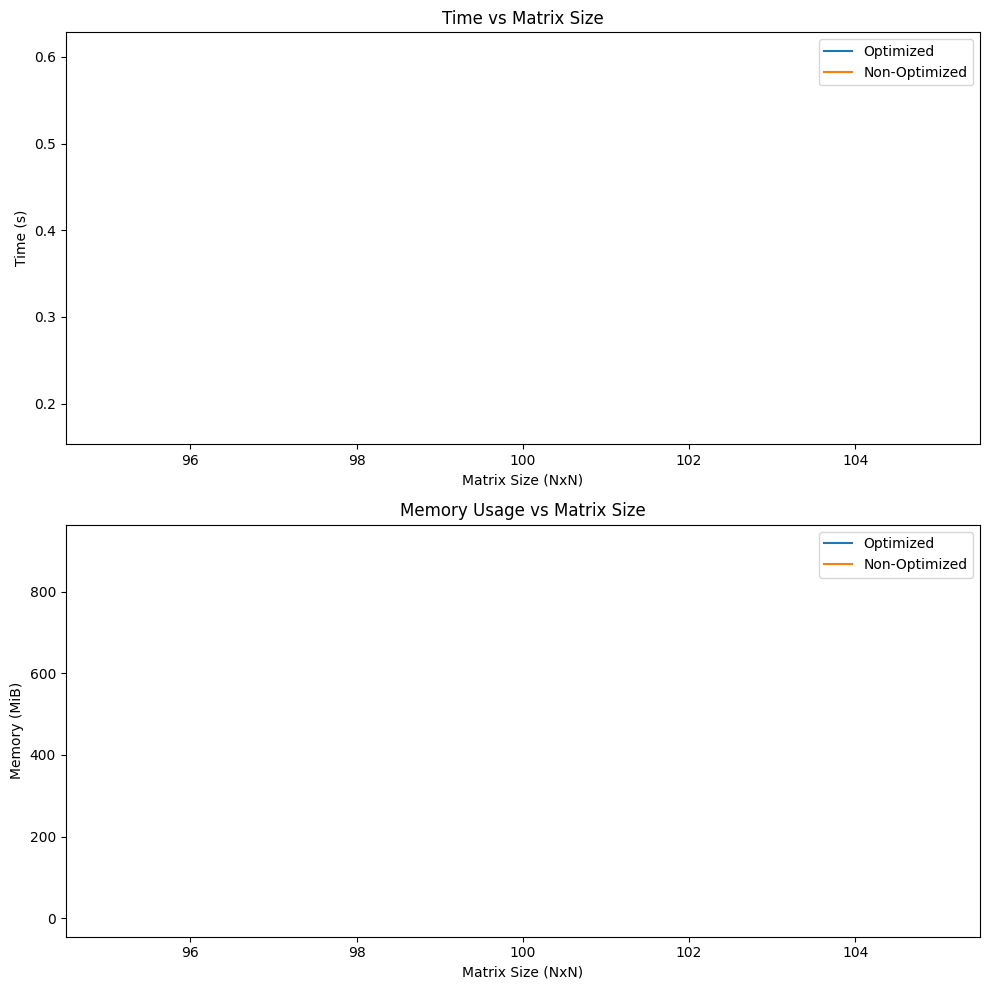

Testing with N_PARTICLES = 10...
Optimized: Time = 0.8647s, Peak Memory = 2.02 MiB
Non-Optimized: Time = 10.0759s, Peak Memory = 9.83 MiB
Plotting results after N_PARTICLES = 10...


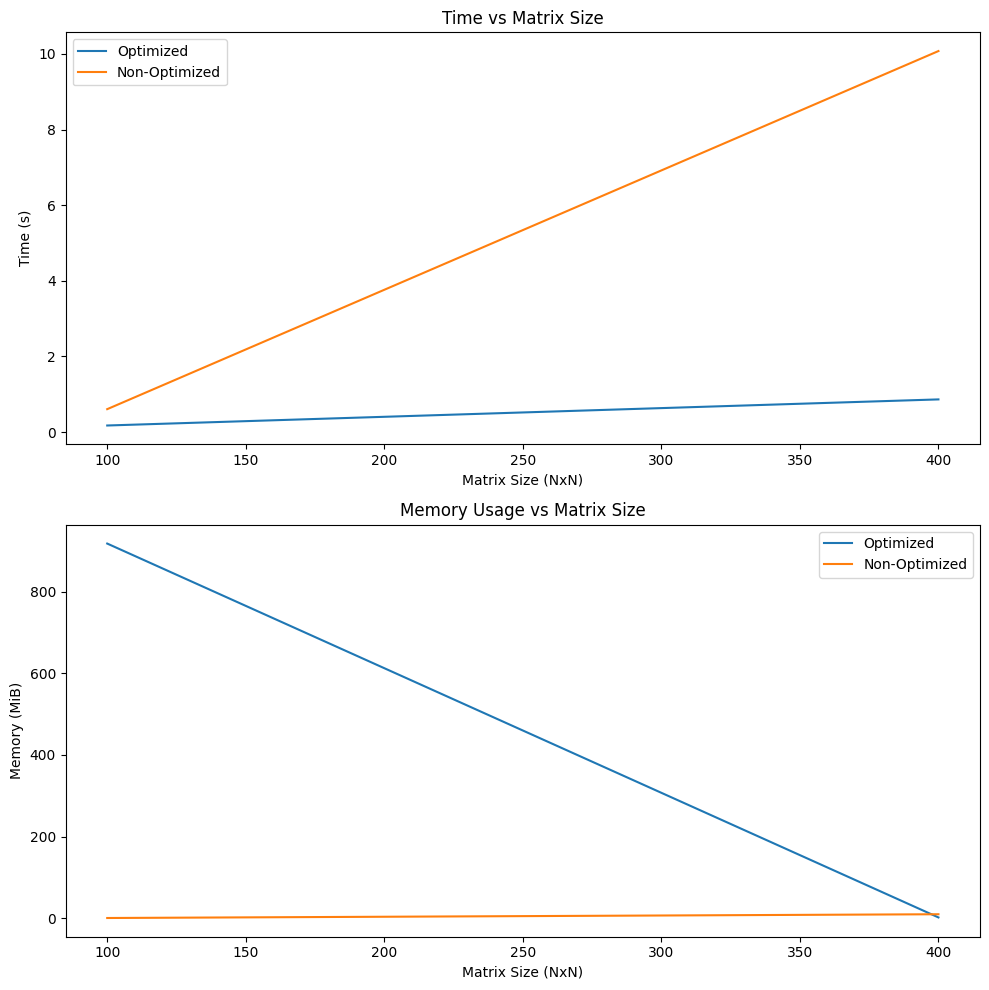

Testing with N_PARTICLES = 15...
Optimized: Time = 2.5584s, Peak Memory = 7.55 MiB
Non-Optimized: Time = 54.0800s, Peak Memory = 49.57 MiB
Plotting results after N_PARTICLES = 15...


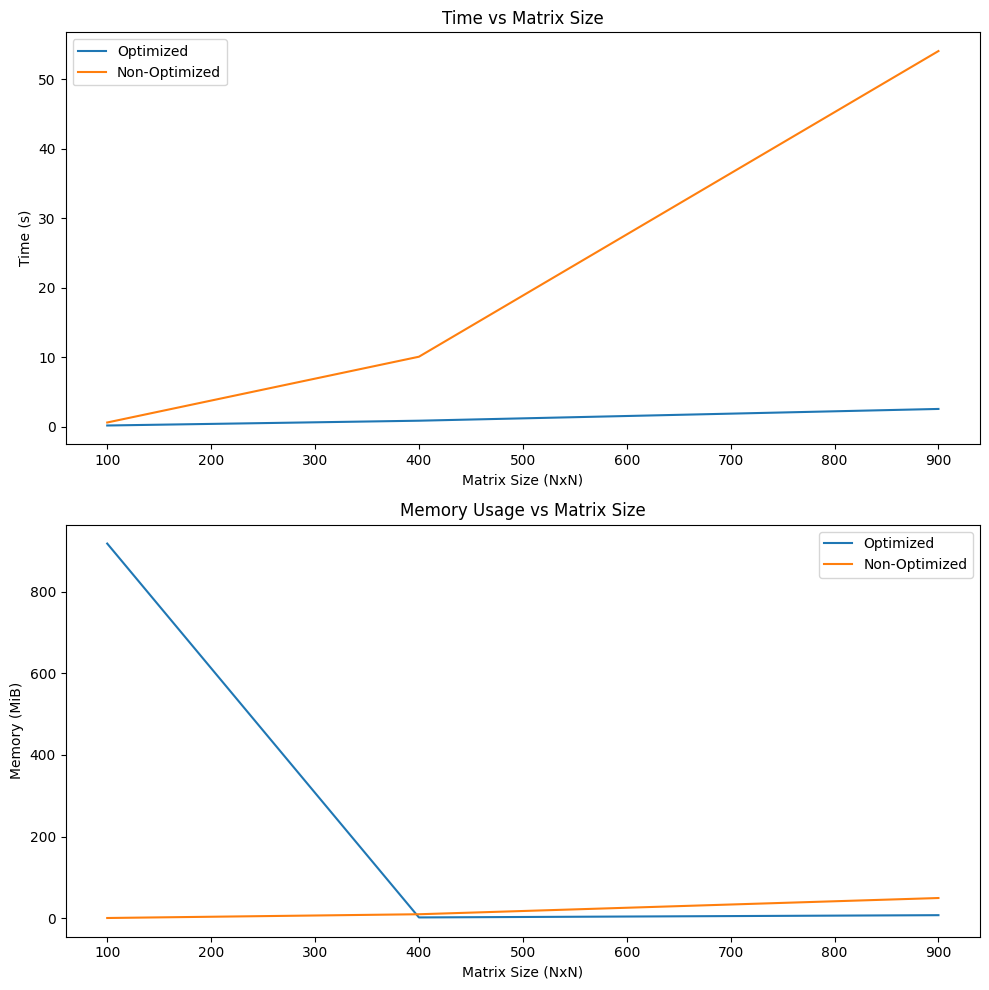

Testing with N_PARTICLES = 20...
Optimized: Time = 7.0176s, Peak Memory = 17.78 MiB
Non-Optimized: Time = 169.8507s, Peak Memory = 156.46 MiB
Plotting results after N_PARTICLES = 20...


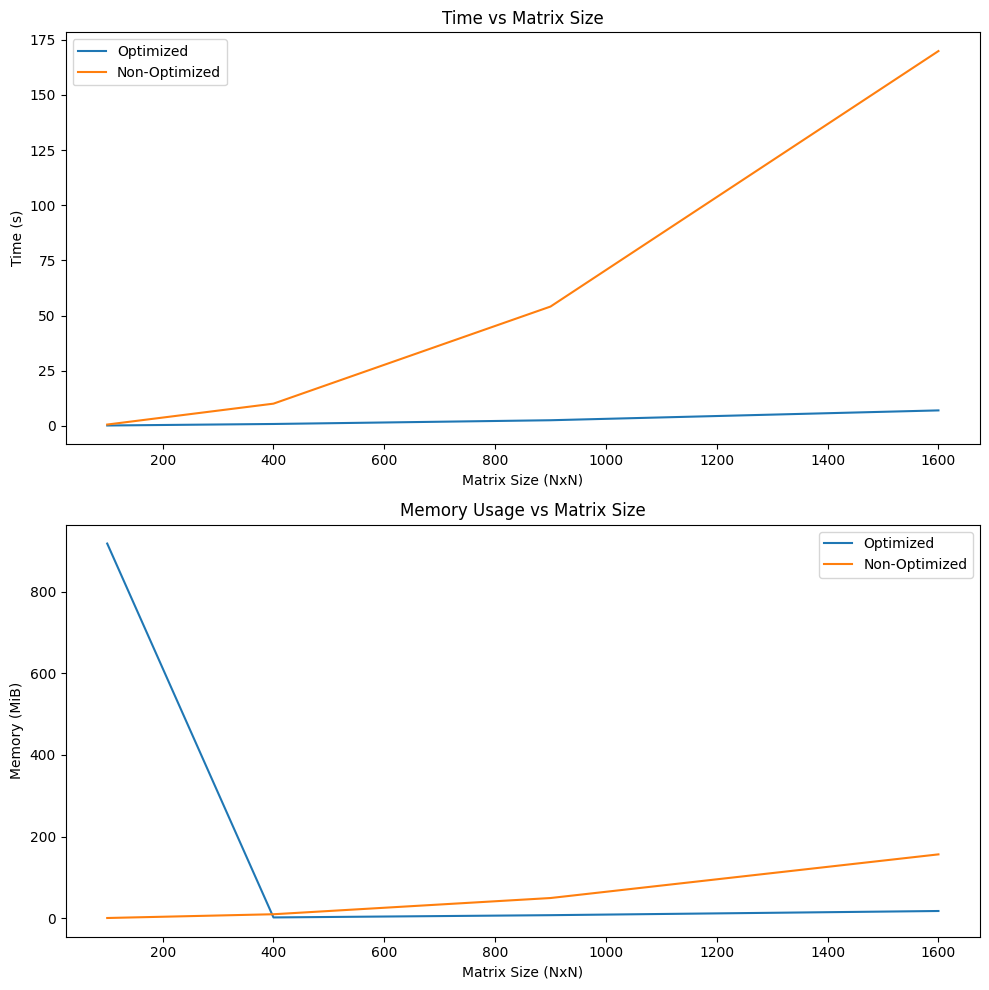

Testing with N_PARTICLES = 25...
Optimized: Time = 15.7424s, Peak Memory = 35.39 MiB
Non-Optimized: Time = 415.4905s, Peak Memory = 381.78 MiB
Plotting results after N_PARTICLES = 25...


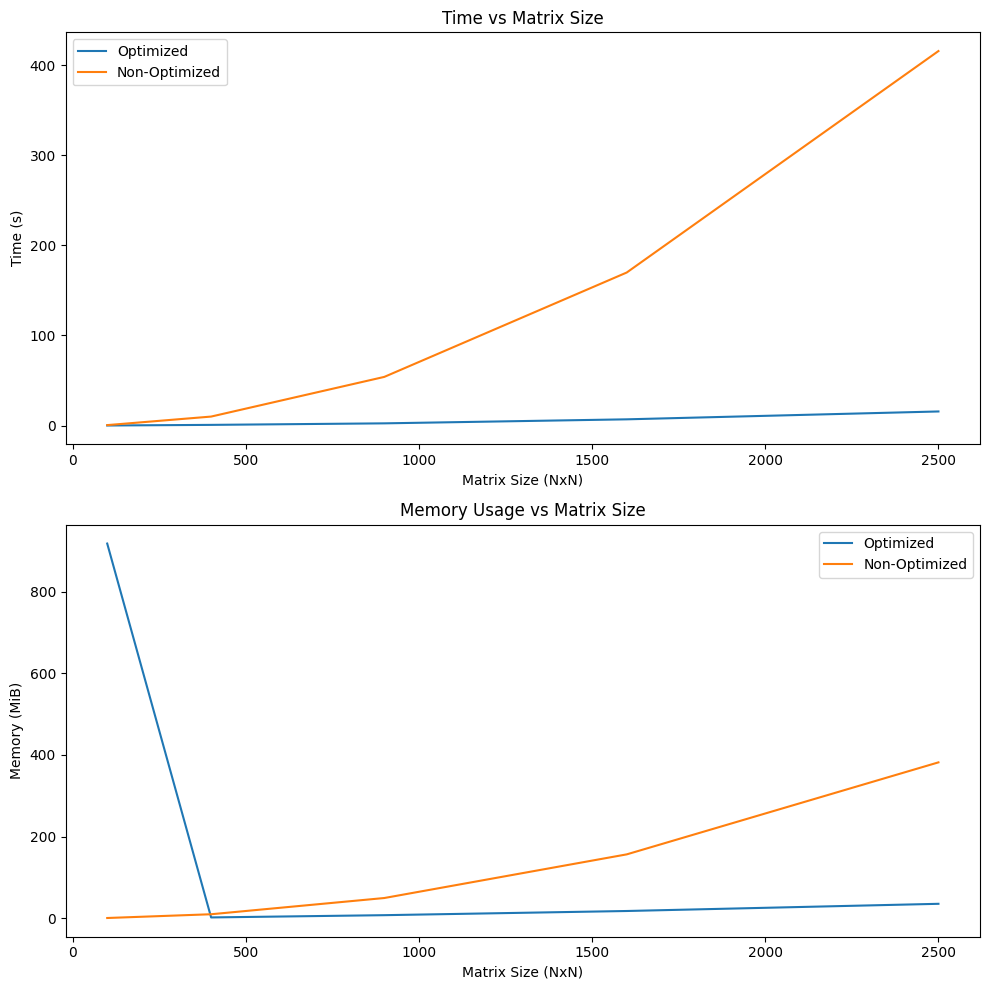

Testing with N_PARTICLES = 30...
Optimized: Time = 35.6292s, Peak Memory = 62.46 MiB
Non-Optimized: Time = 853.2762s, Peak Memory = 791.45 MiB
Plotting results after N_PARTICLES = 30...


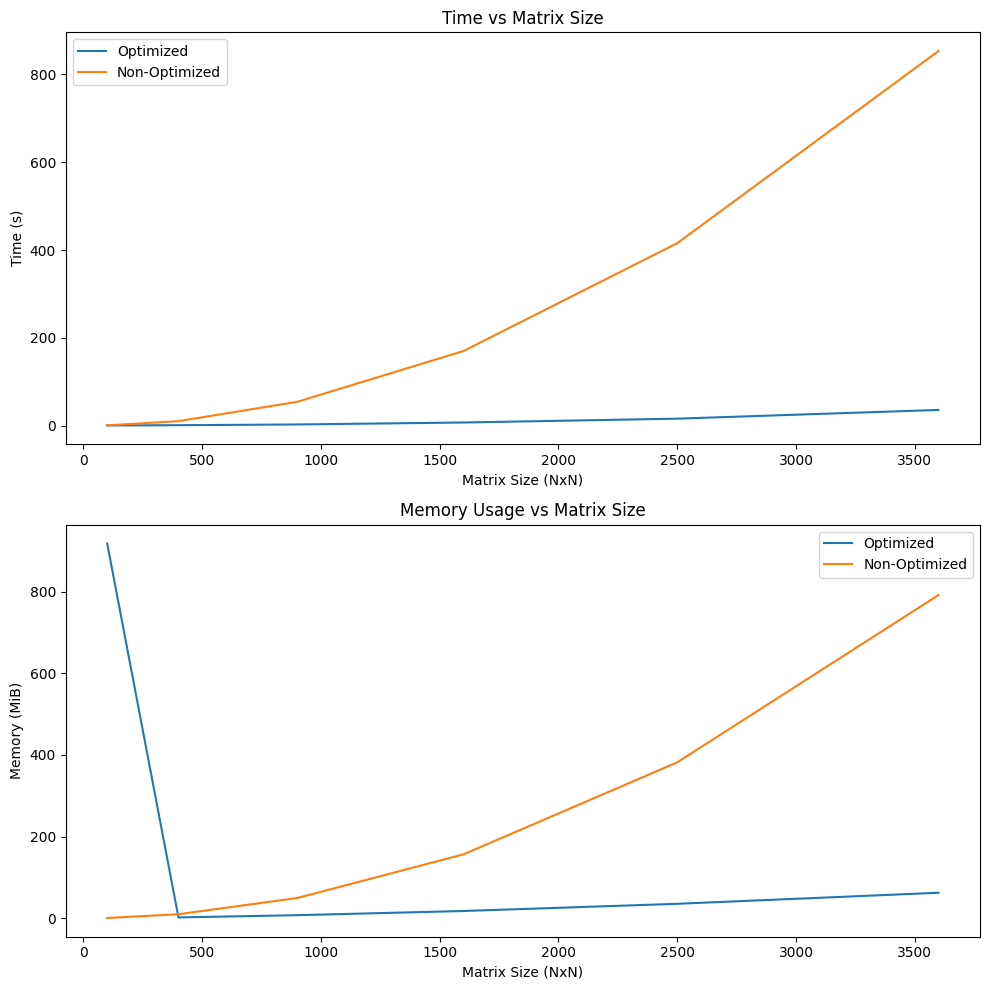

Testing with N_PARTICLES = 35...
Optimized: Time = 66.0843s, Peak Memory = 104.46 MiB
Non-Optimized skipped due to timeout at N_PARTICLES = 35
Plotting results after N_PARTICLES = 35...


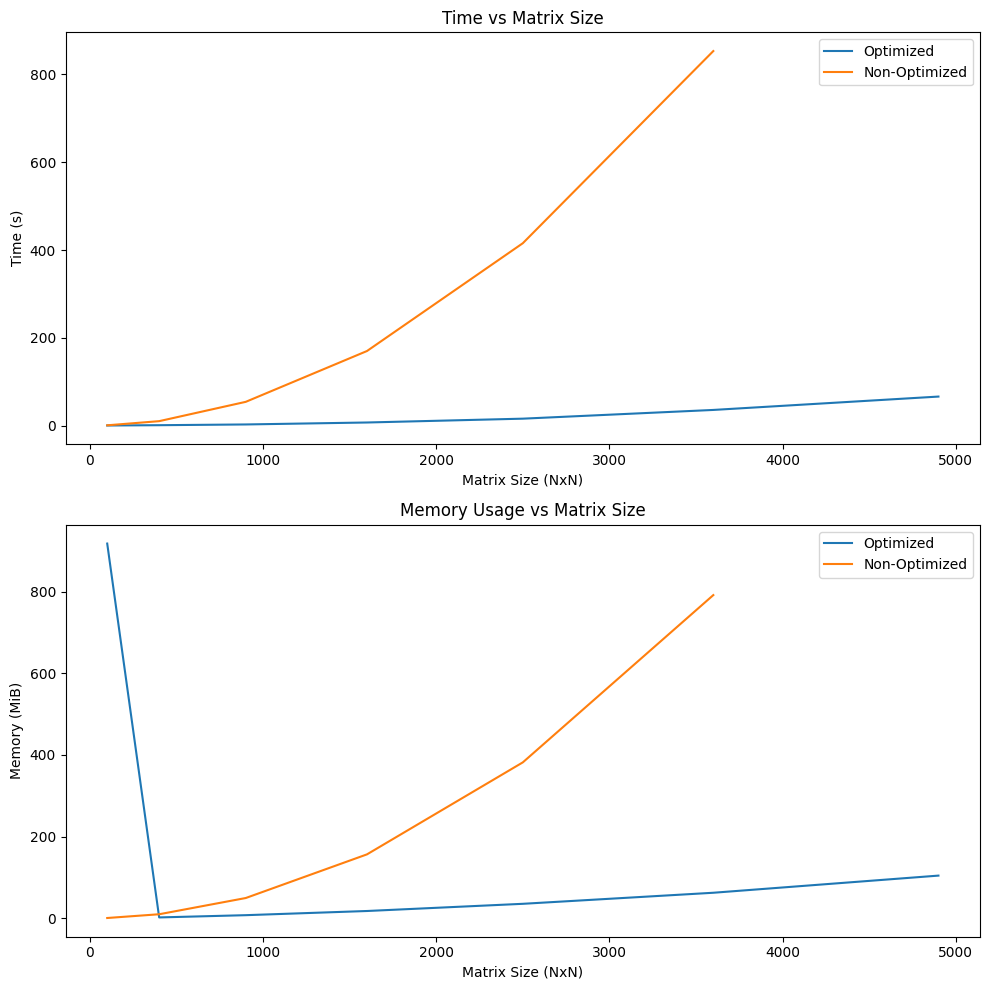

Testing with N_PARTICLES = 40...
Optimized: Time = 143.9383s, Peak Memory = 916.49 MiB
Non-Optimized is excluded from further testing.
Plotting results after N_PARTICLES = 40...


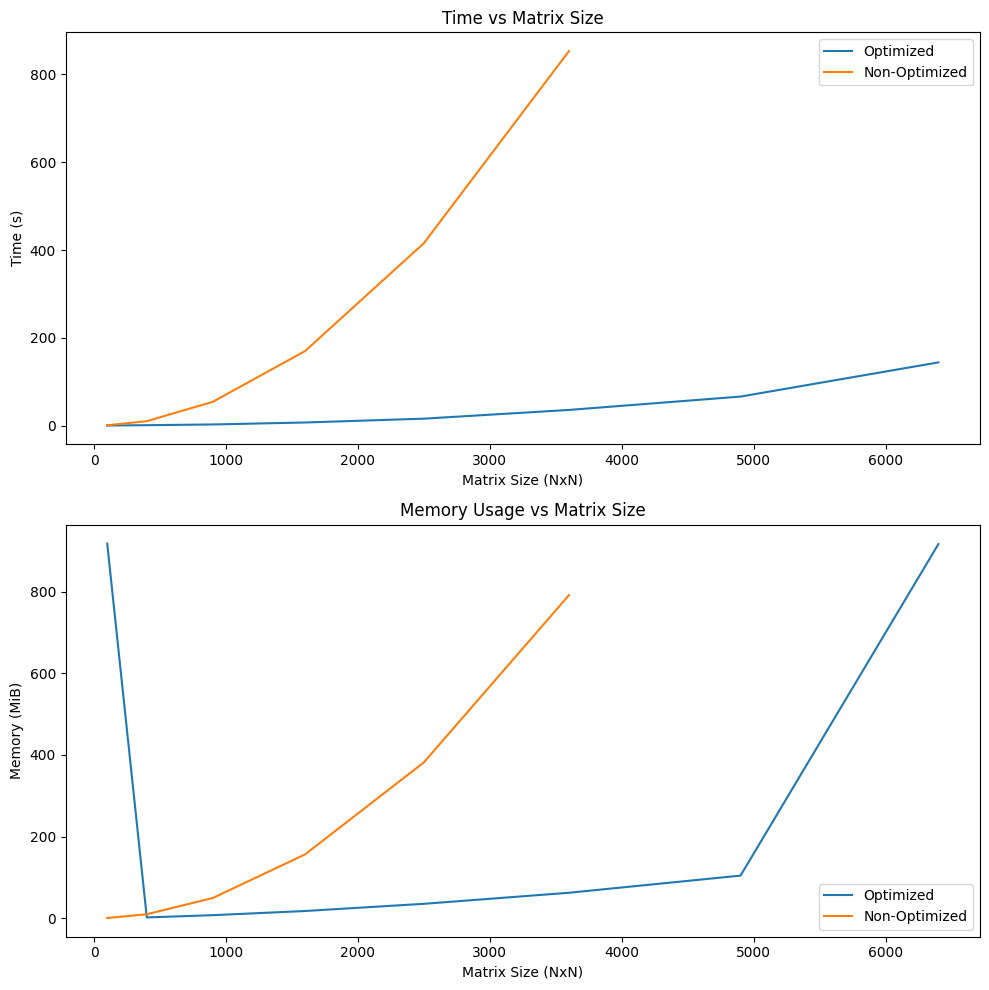

Testing with N_PARTICLES = 45...
Optimized: Time = 236.8946s, Peak Memory = 264.27 MiB
Non-Optimized is excluded from further testing.
Plotting results after N_PARTICLES = 45...


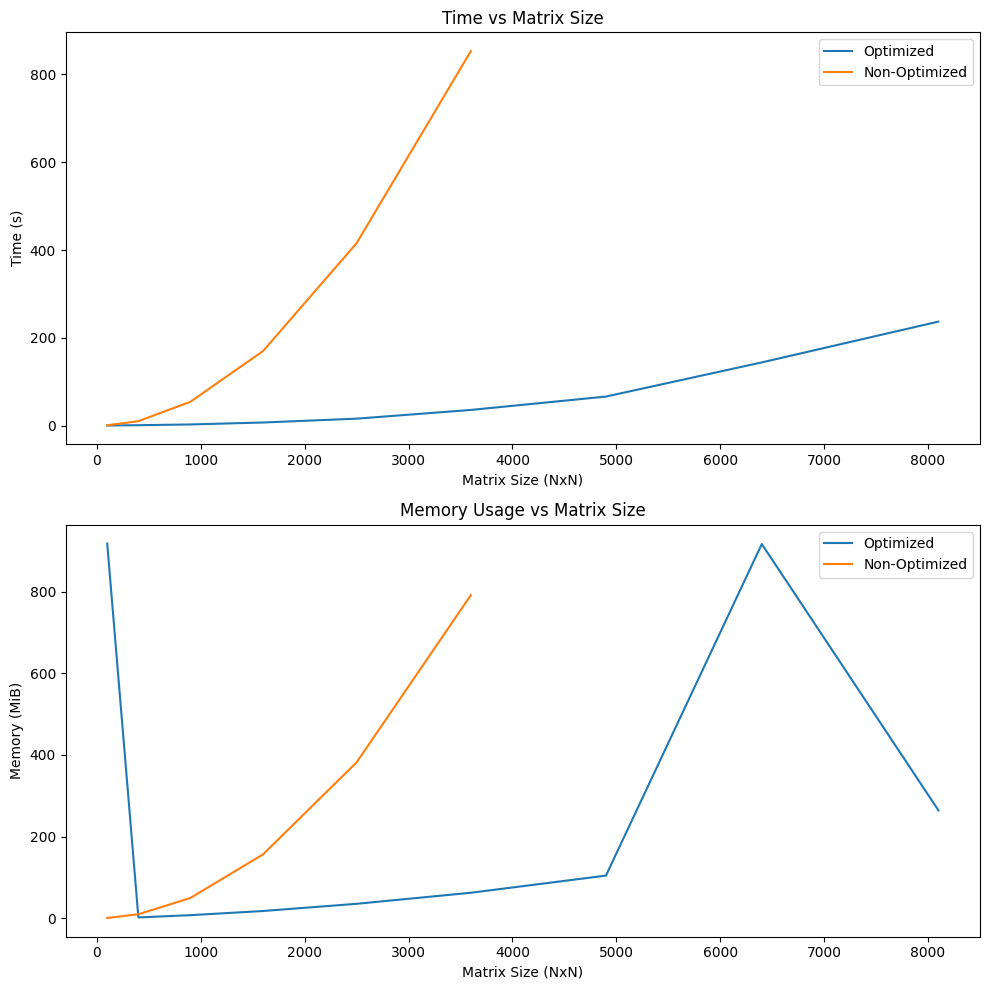

Testing with N_PARTICLES = 50...
Optimized: Time = 404.9539s, Peak Memory = 391.46 MiB
Non-Optimized is excluded from further testing.
Plotting results after N_PARTICLES = 50...


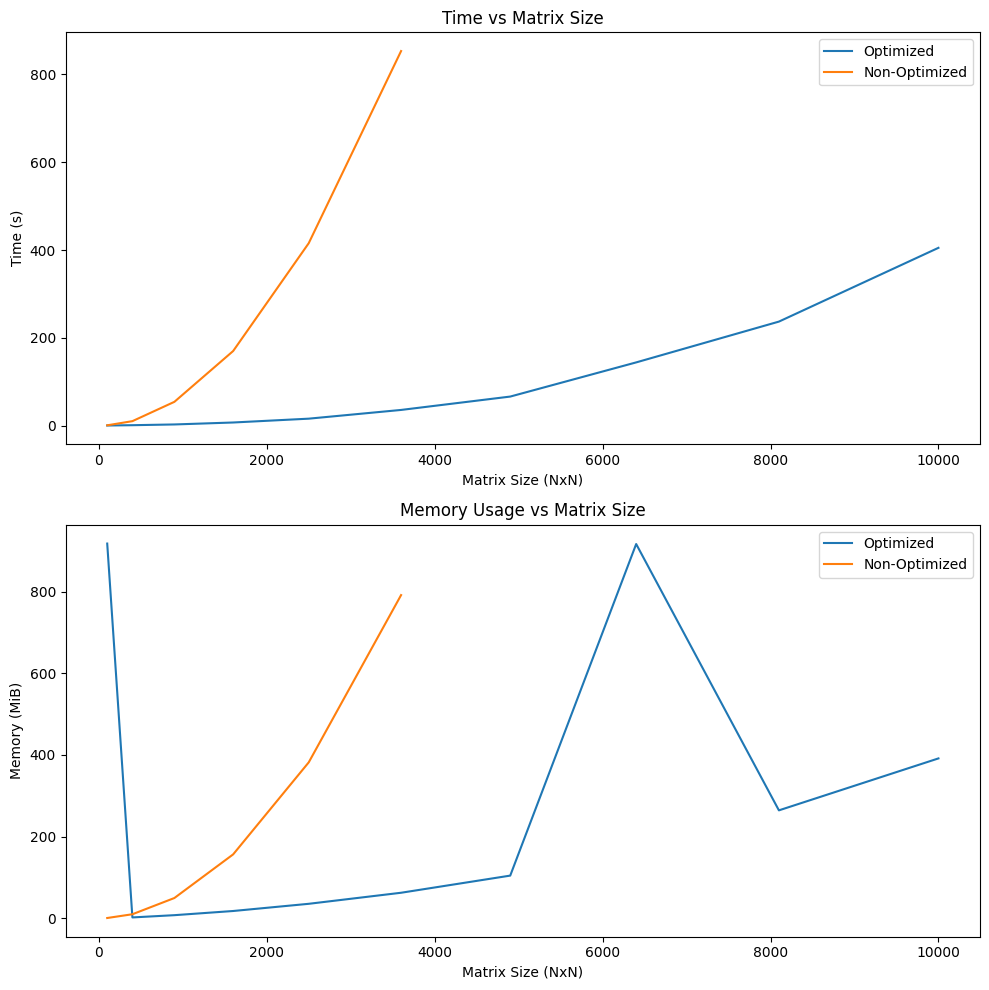

Testing with N_PARTICLES = 55...
Optimized: Time = 933.5196s, Peak Memory = 559.69 MiB
Non-Optimized is excluded from further testing.
Plotting results after N_PARTICLES = 55...


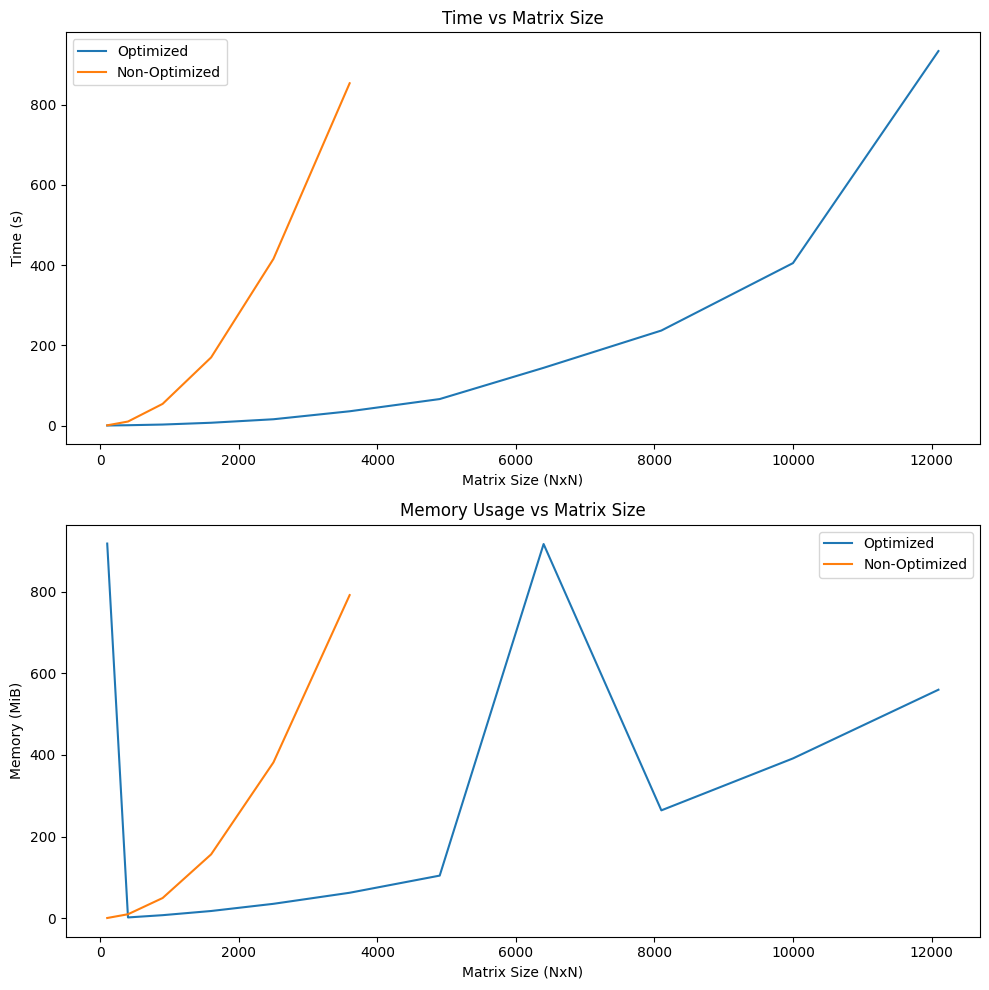

Testing with N_PARTICLES = 60...


KeyboardInterrupt: 

In [12]:
import numpy as np
import time
import tracemalloc
import matplotlib.pyplot as plt
import signal
from collections import defaultdict
import trackhhl.toy.simple_generator 
import trackhhl.event_model.q_event_model

# Timeout exception
class TimeoutException(Exception):
    pass

def timeout_handler(signum, frame):
    """Raise a TimeoutException when a timeout occurs."""
    raise TimeoutException("Function timed out")

# Parameters and setup
N_MODULES = 5
LX = float("+inf")
LY = float("+inf")
Z_SPACING = 1.0

# Initialize detector and generator
detector = SimpleDetectorGeometry(
    module_id=list(range(N_MODULES)),
    lx=[LX] * N_MODULES,
    ly=[LY] * N_MODULES,
    z=[i * Z_SPACING for i in range(N_MODULES)]
)

generator = SimpleGenerator(
    detector_geometry=detector,
    theta_max=np.pi / 6
)

params = {
    'alpha': 1.0,
    'beta': 1.0,
    'lambda': 100.0
}

# List of particle sizes to test
particle_counts = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65]

# Functions to compare
functions = {
    "Optimized": generate_hamiltonian_optimizedPAR,
    "Non-Optimized": generate_hamiltonian
}

# Initialize results containers
time_results = defaultdict(list)
memory_results = defaultdict(list)
matrix_sizes = []
excluded_functions = set()  # To track functions that fail and should be excluded

def measure_performance(func, event, params):
    """Measure time and memory usage of a matrix generation function."""
    # Start tracking memory with tracemalloc
    tracemalloc.start()

    # Time tracking
    start_time = time.time()

    # Execute the function
    A, b, segments = func(event, params)

    # Stop time tracking
    elapsed_time = time.time() - start_time

    # Capture memory statistics
    current, peak = tracemalloc.get_traced_memory()

    # Stop tracemalloc
    tracemalloc.stop()

    # Return elapsed time and peak memory usage in MiB
    return elapsed_time, peak / (1024 * 1024)  # Convert from bytes to MiB

def compute_matrix_size(n_particles, n_modules):
    """Calculate the matrix size based on the number of particles and modules."""
    return n_particles**2 * (n_modules - 1)

def plot_results(matrix_sizes, time_results, memory_results):
    """Plot time and memory usage against matrix size."""
    fig, ax = plt.subplots(2, 1, figsize=(10, 10))

    # Time plot
    ax[0].set_title("Time vs Matrix Size")
    for func_name in time_results:
        y_data = time_results[func_name]
        # Pad y_data with NaN to match matrix_sizes
        y_data = y_data + [np.nan] * (len(matrix_sizes) - len(y_data))
        ax[0].plot(matrix_sizes, y_data, label=func_name)
    ax[0].set_xlabel("Matrix Size (NxN)")
    ax[0].set_ylabel("Time (s)")
    ax[0].legend()

    # Memory plot
    ax[1].set_title("Memory Usage vs Matrix Size")
    for func_name in memory_results:
        y_data = memory_results[func_name]
        # Pad y_data with NaN to match matrix_sizes
        y_data = y_data + [np.nan] * (len(matrix_sizes) - len(y_data))
        ax[1].plot(matrix_sizes, y_data, label=func_name)
    ax[1].set_xlabel("Matrix Size (NxN)")
    ax[1].set_ylabel("Memory (MiB)")
    ax[1].legend()

    plt.tight_layout()
    plt.show()

# Main loop (unchanged)
for N_PARTICLES in particle_counts:
    print(f"Testing with N_PARTICLES = {N_PARTICLES}...")

    # Generate the event for this number of particles
    event = generator.generate_event(N_PARTICLES)

    # Compute and store the matrix size for this iteration
    matrix_size = compute_matrix_size(N_PARTICLES, N_MODULES)
    matrix_sizes.append(matrix_size)

    for func_name, func in functions.items():
        if func_name in excluded_functions:
            print(f"{func_name} is excluded from further testing.")
            continue

        try:
            # Set the timeout handler
            signal.signal(signal.SIGALRM, timeout_handler)
            signal.alarm(1500)  # Timeout in seconds

            # Measure performance
            elapsed_time, peak_mem = measure_performance(func, event, params)
            time_results[func_name].append(elapsed_time)
            memory_results[func_name].append(peak_mem)
            print(f"{func_name}: Time = {elapsed_time:.4f}s, Peak Memory = {peak_mem:.2f} MiB")

            # Disable the alarm
            signal.alarm(0)

        except TimeoutException:
            print(f"{func_name} skipped due to timeout at N_PARTICLES = {N_PARTICLES}")
            time_results[func_name].append(float('inf'))
            memory_results[func_name].append(float('inf'))
            excluded_functions.add(func_name)

        except MemoryError:
            print(f"{func_name} failed with MemoryError at N_PARTICLES = {N_PARTICLES}")
            time_results[func_name].append(float('inf'))
            memory_results[func_name].append(float('inf'))
            excluded_functions.add(func_name)

        except Exception as e:
            print(f"Error in {func_name} at N_PARTICLES = {N_PARTICLES}: {e}")
            time_results[func_name].append(float('inf'))
            memory_results[func_name].append(float('inf'))
            excluded_functions.add(func_name)

        finally:
            # Ensure alarm is disabled
            signal.alarm(0)

    # Plot intermediate results
    print(f"Plotting results after N_PARTICLES = {N_PARTICLES}...")
    plot_results(matrix_sizes, time_results, memory_results)

# Final plot
print("Testing completed. Final plotting...")
plot_results(matrix_sizes, time_results, memory_results)


N_PARTICLES: 10, Matrix size: 400x400, Time taken: 0.618664 s, Peak memory used: 238.29 MB
N_PARTICLES: 15, Matrix size: 900x900, Time taken: 2.950765 s, Peak memory used: 5.04 MB
N_PARTICLES: 20, Matrix size: 1600x1600, Time taken: 9.080826 s, Peak memory used: 13.67 MB
N_PARTICLES: 25, Matrix size: 2500x2500, Time taken: 22.020931 s, Peak memory used: 30.17 MB
N_PARTICLES: 30, Matrix size: 3600x3600, Time taken: 44.915521 s, Peak memory used: 58.43 MB
N_PARTICLES: 35, Matrix size: 4900x4900, Time taken: 82.028694 s, Peak memory used: 102.51 MB


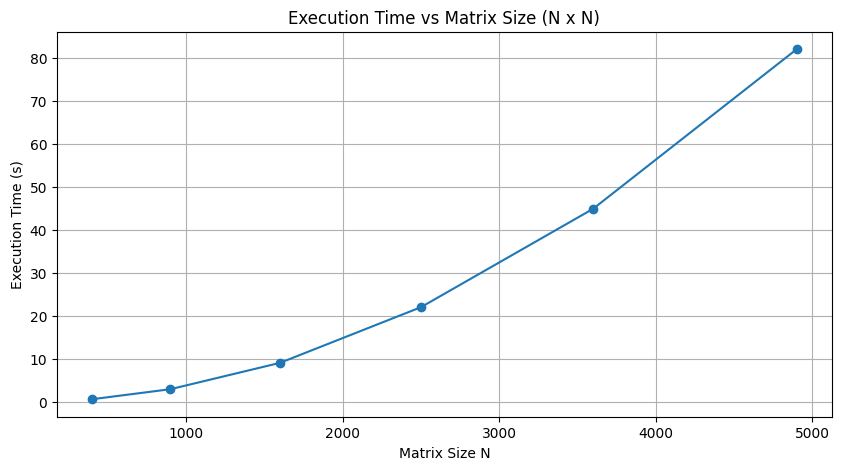

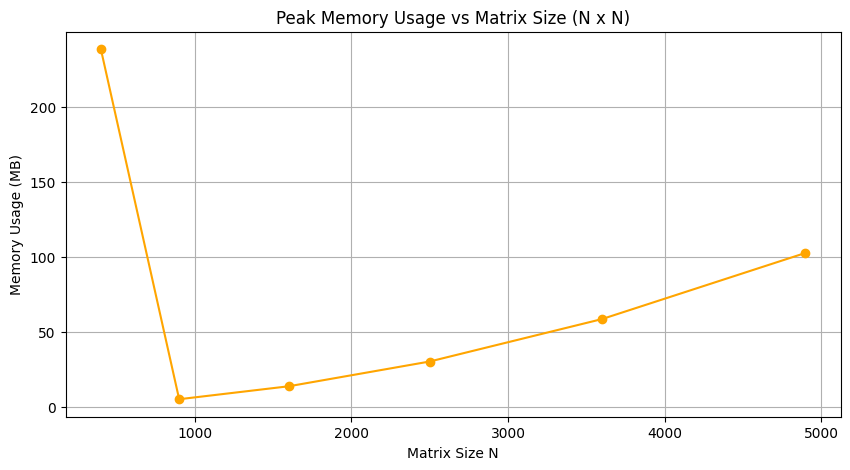

KeyboardInterrupt: 

In [29]:
import trackhhl.toy.simple_generator as toy
import trackhhl.event_model.q_event_model as em
import numpy as np
import itertools
import time
from scipy.sparse import lil_matrix, block_diag
import tracemalloc
import matplotlib.pyplot as plt

# Constants
LX = float("+inf")
LY = float("+inf")
Z_SPACING = 1.0
params = {'alpha': 1.0, 'beta': 1.0, 'lambda': 100.0}

# Lists to store results
particle_counts = [10, 15, 20, 25, 30, 35, 40, 45, 50]  # Adjust this list as needed
matrix_sizes = []
execution_times = []
memory_usages = []



# Main execution with try-except block
try:
    for N_PARTICLES in particle_counts:
        N_MODULES = 5  # Fixed number of modules
        detector = toy.SimpleDetectorGeometry(
            module_id=list(range(N_MODULES)),
            lx=[LX] * N_MODULES,
            ly=[LY] * N_MODULES,
            z=[i * Z_SPACING for i in range(N_MODULES)]
        )
        generator = toy.SimpleGenerator(
            detector_geometry=detector,
            theta_max=np.pi / 6
        )
        event = generator.generate_event(N_PARTICLES)

        # Performance measurement using tracemalloc
        tracemalloc.start()
        start_time = time.time()

        A, b, segments = generate_hamiltonian_blockwise(event, params)

        end_time = time.time()
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()

        memory_used = peak / (1024 ** 2)  # Convert bytes to MB
        time_taken = end_time - start_time

        N = A.shape[0]  # Size of the Hamiltonian matrix

        matrix_sizes.append(N)
        execution_times.append(time_taken)
        memory_usages.append(memory_used)

        print(f"N_PARTICLES: {N_PARTICLES}, Matrix size: {N}x{N}, Time taken: {time_taken:.6f} s, Peak memory used: {memory_used:.2f} MB")

except Exception as e:
    # Handle exceptions during the loop
    print(f"An error occurred: {e}")
    # Stop collecting data
    pass  # The loop will exit due to the exception

finally:
    # Plot the data collected so far
    if execution_times and memory_usages:
        # Adjust matrix_sizes to match the length of collected data
        valid_matrix_sizes = matrix_sizes[:len(execution_times)]

        # Plotting Execution Time vs Matrix Size
        plt.figure(figsize=(10, 5))
        plt.plot(valid_matrix_sizes, execution_times, marker='o')
        plt.title('Execution Time vs Matrix Size (N x N)')
        plt.xlabel('Matrix Size N')
        plt.ylabel('Execution Time (s)')
        plt.grid(True)
        plt.show()

        # Plotting Memory Usage vs Matrix Size
        plt.figure(figsize=(10, 5))
        plt.plot(valid_matrix_sizes, memory_usages, marker='o', color='orange')
        plt.title('Peak Memory Usage vs Matrix Size (N x N)')
        plt.xlabel('Matrix Size N')
        plt.ylabel('Memory Usage (MB)')
        plt.grid(True)
        plt.show()
    else:
        print("No data collected to plot.")
